# Kannst du durch pures Glück in ein viel höheres Rank kommen?

Stell dir vor, du spielst ein Competitive Game wie CS2 oder Valorant. Du bist eigentlich ein durchschnittlicher Spieler - bei deinem wahren Skill-Level gewinnst du etwa 50% deiner Spiele.

**Die Frage:** Kannst du es schaffen, durch pures Glück und gute Teammates weit über dein eigentliches Level zu kommen? Sagen wir von 0 auf 100 Ranking-Punkte?

**Das Problem:** Je höher dein Rank wird, desto schwerer werden die Gegner. Deine Winchance sinkt von 50% am Anfang auf nur noch 15% ganz oben. Aber wenn du unter deinem Start-Rank fällst, wird's wieder leichter (mehr als 50% Winchance).

## Die Rechnung

Die Winchance ändert sich so: `Winchance = 50% - (0,35% × deine Punkte)`

Das bedeutet:
- **Bei 0 Punkten:** 50% Winchance (fair)
- **Bei 50 Punkten:** 32,5% Winchance (wird schwer)
- **Bei 100 Punkten:** 15% Winchance (fast unmöglich)
- **Bei -50 Punkten:** 67,5% Winchance (leichter zu recovern)

## Was wir erwarten

Wahrscheinlich ist es praktisch unmöglich, so weit über sein Level zu kommen. Die meisten werden nie ankommen oder ewig brauchen.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import numba
from joblib import Parallel, delayed

np.random.seed(42)
random.seed(42)

print("Bibliotheken erfolgreich importiert!")

Bibliotheken erfolgreich importiert!


In [2]:
@numba.jit(nopython=True)
def get_winrate(points):
    winrate = 0.5 - (points * 0.0035)
    return max(0.01, min(0.99, winrate))

print("Beispiele für Winrates:")
print(f"Bei -100 Punkten: {get_winrate(-100):.1%}")
print(f"Bei 0 Punkten: {get_winrate(0):.1%}")
print(f"Bei 50 Punkten: {get_winrate(50):.1%}")
print(f"Bei 100 Punkten: {get_winrate(100):.1%}")

Beispiele für Winrates:
Bei -100 Punkten: 85.0%
Bei 0 Punkten: 50.0%
Bei 50 Punkten: 32.5%
Bei 100 Punkten: 15.0%


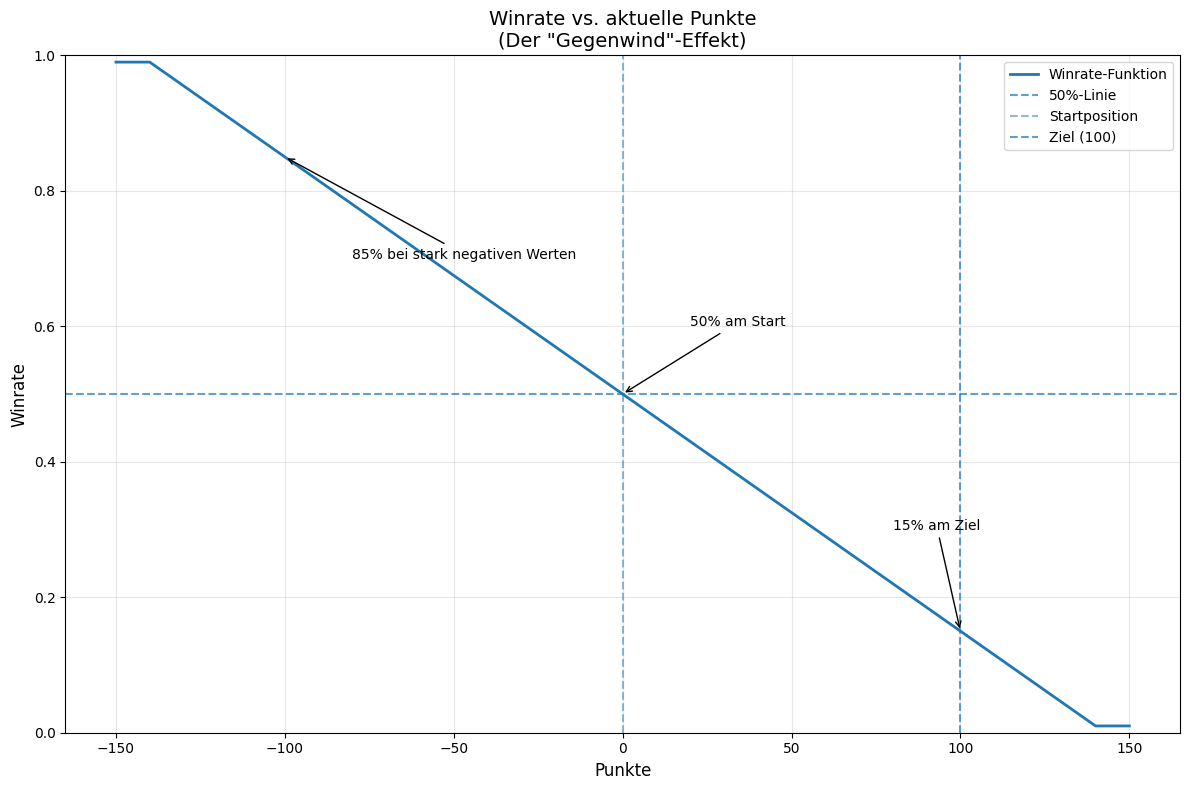

In [3]:
def plot_winrate_function():
    points = np.linspace(-150, 150, 301)
    winrates = [get_winrate(p) for p in points]

    plt.figure(figsize=(12, 8))
    plt.plot(points, winrates, linewidth=2, label='Winrate-Funktion')

    plt.axhline(y=0.5, linestyle='--', alpha=0.7, label='50%-Linie')
    plt.axvline(x=0, linestyle='--', alpha=0.5, label='Startposition')
    plt.axvline(x=100, linestyle='--', alpha=0.7, label='Ziel (100)')

    plt.xlabel('Punkte', fontsize=12)
    plt.ylabel('Winrate', fontsize=12)
    plt.title('Winrate vs. aktuelle Punkte\n(Der "Gegenwind"-Effekt)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(0, 1)

    plt.annotate('50% am Start', (0, 0.5), xytext=(20, 0.6),
                 arrowprops=dict(arrowstyle='->'), fontsize=10)
    plt.annotate('15% am Ziel', (100, 0.15), xytext=(80, 0.3),
                 arrowprops=dict(arrowstyle='->'), fontsize=10)
    plt.annotate('85% bei stark negativen Werten', (-100, 0.85), xytext=(-80, 0.7),
                 arrowprops=dict(arrowstyle='->'), fontsize=10)

    plt.tight_layout()
    plt.show()

plot_winrate_function()

In [4]:
@numba.jit(nopython=True)
def simulate_single_run(target=100, max_steps=50000, track_path=False):
    points = 0
    steps = 0
    min_points = 0
    
    if track_path:
        path = [0]
    else:
        path = None

    while steps < max_steps:
        if points >= target:
            return 1, steps, min_points, path

        winrate = get_winrate(points)
        if np.random.random() < winrate:
            points += 1
        else:
            points -= 1
            min_points = min(min_points, points)

        if track_path:
            path.append(points)

        steps += 1

    return 0, steps, min_points, path

result, steps, min_points, path = simulate_single_run()
print(f"Testergebnis: {'Erfolg' if result==1 else 'Timeout'}")
print(f"Benötigte Schritte: {steps:,}")
print(f"Tiefster erreichter Punkt: {min_points}")

Testergebnis: Timeout
Benötigte Schritte: 50,000
Tiefster erreichter Punkt: -28


In [5]:
def run_single_simulation(target, max_steps, track_this_run=False):
    return simulate_single_run(target, max_steps, track_path=track_this_run)

def run_simulation(num_runs=100000, target=100, verbose=True, n_jobs=-1):
    from collections import defaultdict
    results = defaultdict(int)
    successful_steps = []
    successful_min_points = []
    tracked_paths = []

    if verbose:
        print(f"FLUCHTWAHRSCHEINLICHKEITS-SIMULATION")
        print(f"{'='*50}")
        print(f"Ziel: {target} Punkte")
        print(f"Durchläufe: {num_runs:,}")
        print(f"Winrate: 50% → 15% (0 → {target} Punkte)")
        print(f"Keine negative Grenze (unendliche Versuche)")
        print(f"Parallel Jobs: {n_jobs}")
        print(f"Pfade verfolgt: ~{num_runs//1000:,} (1 von 1000)")
        print(f"{'='*50}")

        start_time = time.time()

    track_indices = set(range(0, num_runs, 1000))
    
    simulation_results = Parallel(n_jobs=n_jobs, verbose=0)(
        delayed(run_single_simulation)(target, 50000, i in track_indices) for i in range(num_runs)
    )

    for i, sim_result in enumerate(simulation_results):
        result, steps, min_points, path = sim_result
        
        if i in track_indices and path is not None:
            tracked_paths.append({
                'run_id': i,
                'result': result,
                'steps': steps,
                'min_points': min_points,
                'path': path
            })
            
        if result == 1:
            results['success'] += 1
            successful_steps.append(steps)
            successful_min_points.append(min_points)
        else:
            results['timeout'] += 1

    total_runs = sum(results.values())
    escape_prob = results['success'] / total_runs if total_runs else 0.0
    timeout_rate = results['timeout'] / total_runs if total_runs else 0.0

    if verbose:
        elapsed = time.time() - start_time
        print(f"\nSIMULATION ABGESCHLOSSEN ({elapsed:.1f} Sekunden)")
        print(f"{'='*50}")
        print(f"Erfolgreiche Durchläufe: {results['success']:,}")
        print(f"Abgebrochene Durchläufe (Timeout): {results['timeout']:,}")
        print(f"Verfolgte Pfade: {len(tracked_paths):,}")
        print(f"")
        print(f"FLUCHTWAHRSCHEINLICHKEIT: {escape_prob:.4%}")
        print(f"{'='*50}")

        if timeout_rate > 0.01:
            print(f" WARNUNG: {timeout_rate:.2%} der Durchläufe liefen in ein Timeout")
            print(f"Erwägen Sie, max_steps für bessere Genauigkeit zu erhöhen")

        if successful_steps:
            print(f"\nANALYSE ERFOLGREICHER DURCHLÄUFE:")
            print(f"Durchschnittliche Schritte bis zum Erfolg: {np.mean(successful_steps):,.0f}")
            print(f"Median der Schritte bis zum Erfolg: {np.median(successful_steps):,.0f}")
            print(f"Schnellster Erfolg: {min(successful_steps):,} Schritte")
            print(f"Langsamster Erfolg: {max(successful_steps):,} Schritte")
            print(f"")
            print(f"Durchschnittlich tiefster Einbruch: {np.mean(successful_min_points):,.1f} Punkte")
            print(f"Schlimmster Einbruch bei Erfolg: {min(successful_min_points):,} Punkte")

    detailed_results = {
        'escape_probability': escape_prob,
        'successful_steps': successful_steps,
        'successful_min_points': successful_min_points,
        'timeout_rate': timeout_rate,
        'tracked_paths': tracked_paths,
        'raw_results': dict(results)
    }

    return escape_prob, detailed_results

print("Simulationsfunktion definiert. Bereit zum Start!")

Simulationsfunktion definiert. Bereit zum Start!


In [6]:
print("Starte Simulation...\n")

escape_probability, results = run_simulation(num_runs=10000000, target=100)

Starte Simulation...

FLUCHTWAHRSCHEINLICHKEITS-SIMULATION
Ziel: 100 Punkte
Durchläufe: 10,000,000
Winrate: 50% → 15% (0 → 100 Punkte)
Keine negative Grenze (unendliche Versuche)
Parallel Jobs: -1
Pfade verfolgt: ~10,000 (1 von 1000)

SIMULATION ABGESCHLOSSEN (711.1 Sekunden)
Erfolgreiche Durchläufe: 0
Abgebrochene Durchläufe (Timeout): 10,000,000
Verfolgte Pfade: 10,000

FLUCHTWAHRSCHEINLICHKEIT: 0.0000%
 WARNUNG: 100.00% der Durchläufe liefen in ein Timeout
Erwägen Sie, max_steps für bessere Genauigkeit zu erhöhen

 ENDGÜLTIGE ANTWORT: Die Wahrscheinlichkeit, jemals 100 Punkte zu erreichen, beträgt 0.0000%


## Das Ergebnis: Unmöglicher Rank-Boost

Nach 10 Millionen Versuchen das Urteil: **0% Erfolgsquote**. Kein einziger Spieler hat es geschafft.

Das ist wie wenn du hoffst, durch pure Glückssträhnen und Carries von deinem wahren Skill-Level (50% Winrate) auf einen deutlich höheren Rank zu kommen. Am Anfang klappt das noch, aber je höher du kommst, desto krasser werden die Gegner. Irgendwann verlierst du 85% deiner Spiele und fällst unweigerlich wieder runter.

**Die harte Wahrheit:** Extreme Rank-Boosts nur durch Glück sind mathematisch unmöglich. Das Ranking-System zieht dich immer zurück zu deinem wahren Skill-Level. Wer richtig hoch will, muss besser werden - nicht auf Glück hoffen.

In [7]:
def plot_tracked_paths_with_winrate(detailed_results, max_paths=10):
    tracked_paths = detailed_results['tracked_paths']
    
    if not tracked_paths:
        print("Keine verfolgten Pfade zum Plotten vorhanden.")
        return
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
    
    paths_to_plot = min(max_paths, len(tracked_paths))
    for i in range(paths_to_plot):
        path_data = tracked_paths[i]
        path = path_data['path']
        steps = len(path)
        
        color = 'green' if path_data['result'] == 1 else 'red'
        alpha = 0.7 if path_data['result'] == 1 else 0.3
        
        ax1.plot(range(steps), path, alpha=alpha, color=color, linewidth=1)
    
    ax1.axhline(y=0, linestyle='--', alpha=0.5, color='black', label='Start (0)')
    ax1.axhline(y=100, linestyle='--', alpha=0.7, color='blue', label='Ziel (100)')
    ax1.set_ylabel('Punkte')
    ax1.set_title(f'Random Walk Pfade (erste {paths_to_plot} von {len(tracked_paths)} verfolgten Pfaden)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    points = np.linspace(-200, 150, 351)
    winrates = [get_winrate(p) * 100 for p in points]
    
    plt.tight_layout()
    plt.show()
    
    if tracked_paths:
        print(f"\nSTATISTIKEN DER VERFOLGTEN PFADE:")
        print(f"Erfolgreich: {sum(1 for p in tracked_paths if p['result'] == 1)} von {len(tracked_paths)}")
        min_points = [p['min_points'] for p in tracked_paths]
        print(f"Durchschnittlich tiefster Punkt: {np.mean(min_points):.1f}")
        print(f"Extremster Einbruch: {min(min_points)}")

print("Plotting-Funktion für Pfade definiert!")

Plotting-Funktion für Pfade definiert!


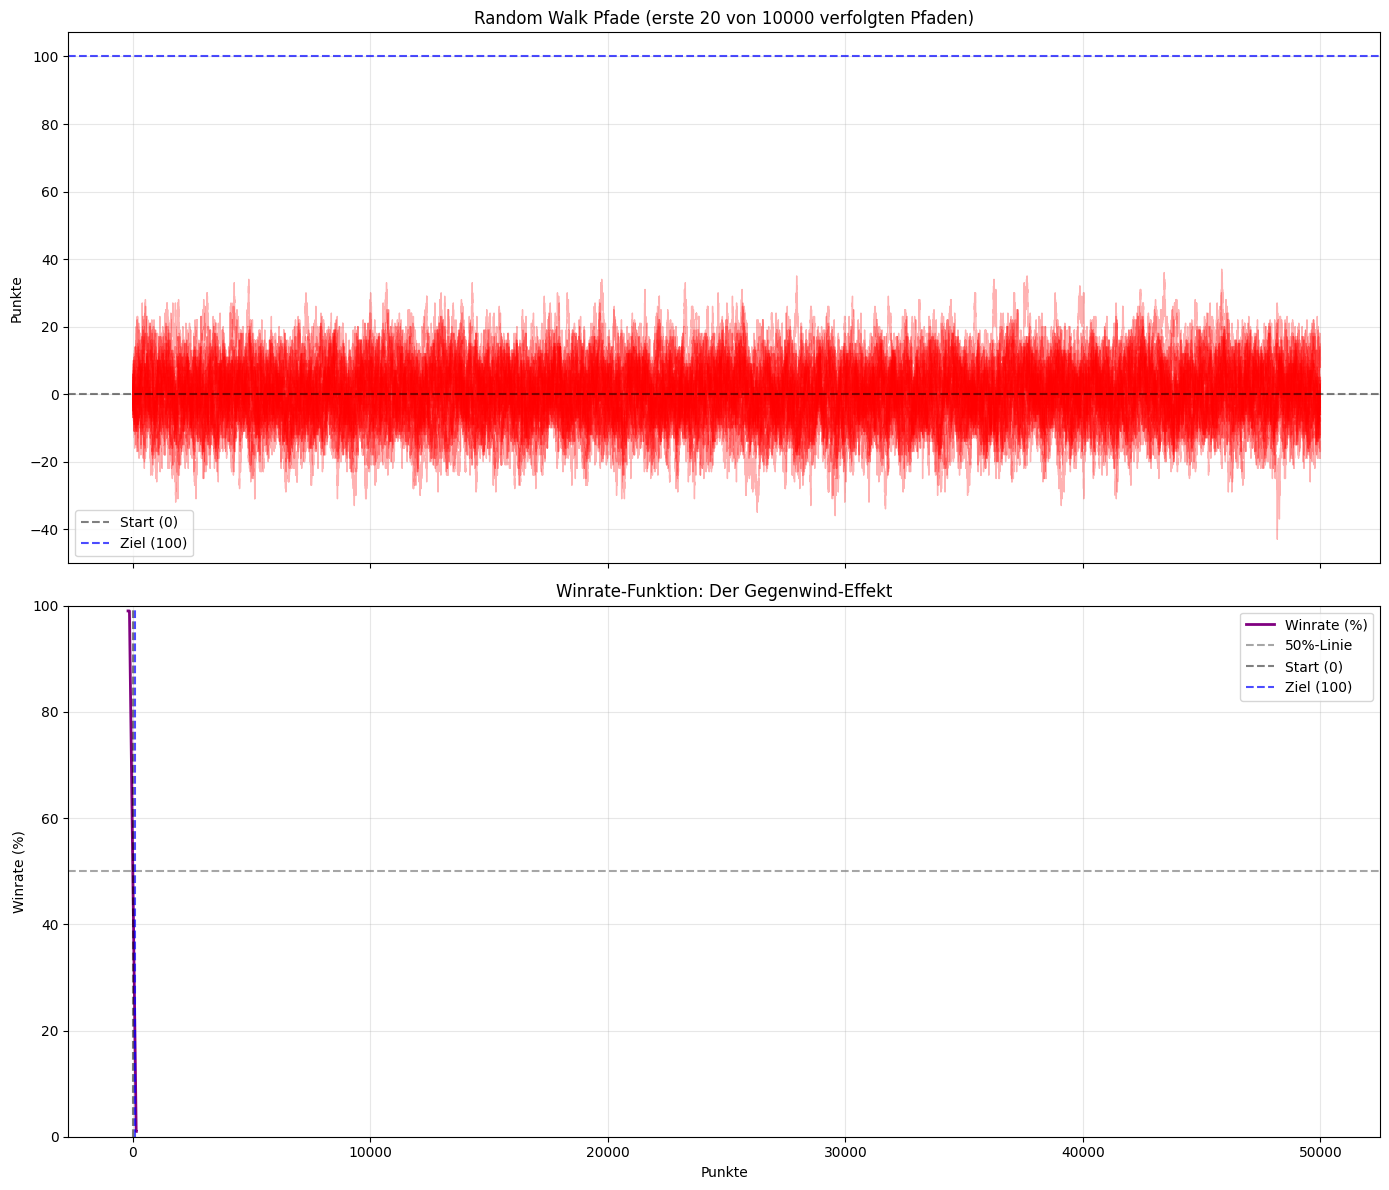


STATISTIKEN DER VERFOLGTEN PFADE:
Erfolgreich: 0 von 10000
Durchschnittlich tiefster Punkt: -30.2
Extremster Einbruch: -45


In [8]:
# Cell: Plot the tracked paths from our simulation
plot_tracked_paths_with_winrate(results, max_paths=20)